# Convolutional Neural Networks (CNNs) - Part 3
## Transfer Learning with CNNs

In this last chapter of the CNN task, you will take a look at the topic of transfer learning using CNNs as an example. It is quite possible that you will use transfer learning in the "Into the Wild" part. So stay tuned!

## 3.1 Basics

As we tackle more intricate problems with machine learning, our models tend to get bigger and more complex. For deep neural networks, this means larger layers and more layers overall, among other things that can be optimized. 

You surely remember (if not, have a look at [Part 1](1_intro_cnn.ipynb)), that one of the main ideas of a CNN layer is, to reduce the amount of weights that have to be trained, by utilizing the spatial arrangement in for example images. However, when models increase, this "parameter saving method" mitigates and we end up again with lots of weights that have to be trained. So, what are we going to do about it? 

Well, transfer learning might be a solution. The idea is, that models are **pretrained** on big datasets with lots of processing power. This is often undertaken by universities or companies. Some of them publish their models, for example on [PyTorch](https://pytorch.org/vision/0.8/models.html) or [Hugging Face](https://huggingface.co/models). We can utilize these models by **fine-tuning** them on our problem. Hence, most of the time some layers are frozen while others are trained on our data. Sometimes we add or exchange layers. This whole process is often used in the fields of Computer Vision and Natural Language Processing.

<img src="images/nomalMLvsTransferLearning.png" alt="drawing" width="700"/>

Source: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

## 3.2 Advantages of Transfer Learning

There might even be some more advantages, however the main ones can the found in the following:

1. We often need a lot less training time, because the weights are not randomly initialized and sometimes only parts of the model are trained. 

2. We can achieve decent results with small datasets. Data is often a sparse resource and creates a bottleneck for machine learning models. It is not uncommon, that human annotators are paid, to label thousands of samples. Avoiding this is time and money saving.

3. The resulting models tend to be more robust and less prone to overfitting, because they have seen so much data during the pretraining stage. For example, BERT, a natural-language processing model was pretrained on 3.3 billion words. GPT-3 was trained on 400 billion tokens (snippets of words)!

4. We do not have to experiment with different net topologies, as we back upon already tested and deployed models. 

## 3.3 Transfer Learning Procedure with CNNs for Image Classification

The advantages sound promising, right? However, we still have to put some work into our models, to fine-tune them on our dataset. But how does this work in detail? 

There are different approaches to it. A CNN model for image classification has some convolutional layers, before ending in some fully connected layers (FCL). These FCLs are usually chopped-off, because they decide finally, to what class the sample belongs and we have probably different classes. Hence, we have to create our own FCLs and train them during our fine-tuning process. The rest of the weights (the filters) can be frozen. They don't have to though. We can also decide to freeze some of them or none.

As a rule of thumb: The more training samples you have, the more layers can be unfrozen. The more you unfreeze, the longer the training lasts. 


## 3.4 Overall Task Description

In the following, we are going to use transfer learning, to fine-tune a [resnet-18](https://arxiv.org/abs/1512.03385) model on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Please make yourself familiar with the dataset and the model we are going to use. You don't have to use the links provided. The paper is maybe to complicated for the beginning. 


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.transforms import ToTensor



# enable inbuilt auto-tuner
cudnn.benchmark = True
# enable interactive mode
plt.ion()

## Loading Data

As you can see, fetching the data is very easy. At least when it comes to famous datasets. We can download it directly into our folder data and transform it directly into a tensor. Similar functionalities exist for Hugging Face as well. 

In [2]:
# load data from internet

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

image_datasets = {"train":training_data, "test":test_data}

## Having a look at the Data

The dataset consists of 10 classes. The following code takes randomly 9 samples and plots them with the respective labels.

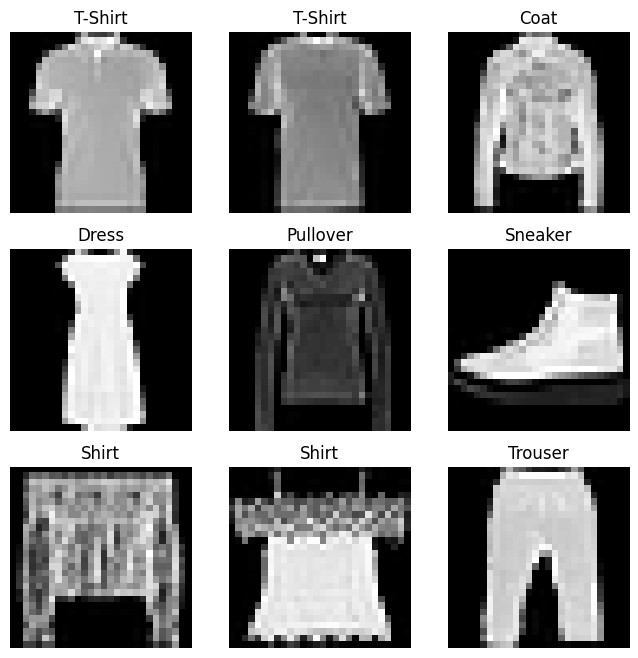

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Create Dataloaders

<div class="alert alert-block alert-success">
<b>Task:</b> 
We feed the data into our model via Dataloaders. They deal with batching, shuffling etc.
<ul>
<li> Load the training data in the dataloader with a batch size of 64 and shuffle True. Do the same for the test data.
<li> Save them both in a dict object with the keys "train" and "test". The dict object has the name dataloaders. 
</ul>

Hint: Have a look into the PyTorch documentation. <a href="https://pytorch.org/docs/stable/index.html"> Link</a>
</div>

In [4]:
### STUDENT CODE HERE (1pt)

train_dataloader = torch.utils.data.DataLoader(
    training_data,        
    batch_size=64,   
    shuffle=True  
)
test_dataloader = torch.utils.data.DataLoader(
    test_data,     
    batch_size=64,  
    shuffle=True   
)
dataloaders = {
    "train": train_dataloader,    
    "test": test_dataloader 
}

### STUDENT CODE until HERE

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = training_data.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Create Visualization Function
By now, we were just able to randomly show some samples. Here, we create a function that we can use to plot specific samples from our train or test dataset.

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""

    # changing from (C,H,W) to (H,W,C)
    inp = inp.numpy().transpose((1, 2, 0))

    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    return plt.imshow(inp, cmap="gray")

def visualize_specific_sample(model, sample, data):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        input = data[sample][0]
        label = torch.tensor(data[sample][1])

        input_batched = input[None,:,:,:]
        input_batched = input_batched.to(device)
        label = label.to(device)

        outputs = model(input_batched)
        _, preds = torch.max(outputs, dim=1)

        # iterating over images contained in the batch
        images_so_far += 1
        ax = plt.subplot(1,1,1)
        ax.axis("off")
        ax.set_title(f'predicted: {class_names[preds]}')
        imshow(input.cpu().data)

        model.train(mode=was_training)

## Training Loop

<div class="alert alert-block alert-success">
<b>Task:</b> 
Attention here comes your next task. In the following, you find the training loop. You will complete some parts of it. 
<ol>
<li> Transfer the inputs and labels to our device. This is done with torch.Tensor.to(). Afterwards, zero the gradients.
<li> Make the prediction with the model, get the argmax() of the prediction and calculate the loss by comparing outputs and labels.
<li> Calculate the backward pass and make the optimization step. Make sure that this is happening only during the training stage.
</ol>

Hint: Have a look into the PyTorch documentary.
</div>

In [6]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):

                    # 1. transfer the inputs and labels to the device, before zeroing the gradients here
                    '''
                    *) Wieso werden die Gradienten auf Null gesetzt? -> Weil wir nach jedem Batch frsch anfangen wollen und PyTorch standardmäßig die Gradienten immer akkumuliert!
                    -> Also wir sagen quasi, nach jedem batch sollen die Gradienten auf Null gesetzt werden, sodass wir von vorne sauber anfangen können.
                    '''
                    ### STUDENT CODE HERE (1pt)
                    inputs = inputs.to(device) # .to(device) -> Erstellt eine Kopie des Tensors auf dem richtigen Device 'cuda, wenn verfügbar sonst cpu'
                    labels = labels.to(device)
                    optimizer.zero_grad() # Ohne diesen Schritt würden sich die Gradienten von verschiedenen Batches addieren
                    ### STUDENT CODE until HERE

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):

                        # 2. caluclate the output, the argmax() of the output and the loss here
                        ### STUDENT CODE HERE (2pts)
                        outputs = model(inputs) # Forward Pass -> Gib die Inputs durch das Modell
                        _, preds = torch.max(outputs, 1) # Die max()-Funktion gibt uns 2 Werte raus, den Max. und sein Idex in der Liste, wir wollen den Index deswegen haben wir gesagt _,
                        loss = criterion(outputs, labels) # criterion ist die Loss-Funktion -> Sie gibt eine einzelne Zahl zurück, die angibt, wie "falsch" die Predictions sind

                        ### STUDENT CODE until HERE

                        # 3. Backward pass here and the step. Make sure that this is only happening in the training stage
                        ### STUDENT CODE HERE (1pt)
                        if phase == 'train': # Diese Bedingung ist wichtig, da wir nur Optemieren wollen, wenn wir im training sind und nicht beim testen!!!
                            loss.backward() # -> Jetzt machen Backpropagation durch das gesamte Netzwerk
                            optimizer.step() # -> Und hier führen wir den eigentlichen Optemierungsstep durch -> Das ist Gradient Descent!
                        ### STUDENT CODE until HERE

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Hyperparameters and Model adjustments

Here, we are going to set the hyperparameters. This process should be familiar for you. However, additionally, we need to adjust our model. 

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> The model was pretrained on the imagnet dataset with color images, while we want to adjust it on gray scale images. 
<ul>
<li> What problem occurs? 
<li> There are two approaches to fix this. What are they? 
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
<ul> 
<li> Das vortrainierte ResNet-18 Modell wurde auf ImageNet mit Farbbildern trainiert, die drei Farbkanäle (RGB) haben. -> Und Fashion MNIST hat nur ein Farb-Kanal. Daher bekommen wir ein Dimensionsfehler.
<li> 1- Der erste Ansatz ist, die Eingabebilder anzupassen, indem wir den einzelnen Graustufen-Kanal dreimal replizieren 2- Der zweite Ansatz ist, das Modell anzupassen, indem wir den ersten Convolutional Layer modifizieren, sodass er nur einen Eingangskanal akzeptiert.
</ul>
</div>

<div class="alert alert-block alert-success">
<b>Task:</b> Hopefully you read this after you answered the questions above. Because for the next part, you need to know what we are going to do and how we decided to solve the problem. We will adjust the first layer of our model, to enable it to process grayscale images with only one channel. 
<ol>
<li> Download the resnet18 model via torchvision.models. Initialize the weights with "IMAGENET1K_V1".
<li> Change the dimension of the first convolutional layer to 1.
<li> Set the weights of the first convolutional layer with torch.nn.Parameter as sum of the weights of the first convolutional layer.  
</ol>

Hint: Use the function torch.sum() and make sure keepdim=True
</div>

In [7]:
### STUDENT CODE HERE (2pt)
'''
*) Pytorch bietet verschiedene vortrainierte Gewichte für ResNet-18 an. In der Aufgabe ist explizit nach den Gewichten "IMAGENET1K_V1" gefragt
*) "IMAGENET1K_V1" bedeutet, dass das Modell auf dem ImageNet-Datensatz mit einer Million Bildern und tausend Klassen trainiert wurde.
*) 
'''
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print(f'Vor der Transformation {model_ft.conv1}') # hiermit können wir uns die Dimension des ersten Conv. Layers anschauen
model_ft.conv1.in_channels = 1 # Mit dem Attribut in_channels können wir gezielt die Anzahl Kanäle ändern. 
model_ft.conv1.weight = torch.nn.Parameter(
    torch.sum(model_ft.conv1.weight, dim=1, keepdim=True)
)
print(f'Nach der Transformation {model_ft.conv1}')
### STUDENT CODE until HERE

Vor der Transformation Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Nach der Transformation Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


<div class="alert alert-block alert-success">
<b>Task:</b> Almost done! Now you are going to chop off the fully connected layer at the end of our model. We are going to train a new new one.
<ol>
<li> Retrieve the in_features of the fully connected layer.
<li> Overwrite the fully connected layer of the model with the desired dimensions.
<li> Send the model over to our device. 
<li> Define a loss function. It should be cross entropy loss.
</ol>

Hint: The input size of the FC has to be the same, as the in_features. 
</div>

In [8]:
### STUDENT CODE HERE (2pt)
print(model_ft.fc) # Hiermit können wir erstmal sehen, wie viele in_feature in das Fully Connected Layer kommt. 
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10) # Mit der Funktion nn.Linear() können wir ein Layer bauen, der fully connected ist, mit dem der vor ihm ist. und mit den paramtern bestimmen wir (input,output)
model_ft = model_ft.to(device) # Hiermit schicken wir das Modell zur GPU/CPU
criterion = nn.CrossEntropyLoss() # UNd hiermit machen wir die Loss-Funktion und zu berachten ist, dass damit auch die SoftMax-Funktion enthalten ist. D.h. wir müssen sie NICHT nochmal drauf tun
### STUDENT CODE until HERE

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=1000, bias=True)


## Training

<div class="alert alert-block alert-success">
<b>Task:</b> Set it all together. Call the training function with the correct arguments. Let it run for 25 epochs. Save the model afterwards to your folder "models".
</div>

In [9]:
### STUDENT CODE HERE (1pt)

model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler, 
    num_epochs=25
)
os.makedirs('models', exist_ok=True)
torch.save(model_ft.state_dict(), 'models/resnet18_fashion_mnist.pth')
print("\n Training abgeschlossen!")
### STUDENT CODE until HERE

Epoch 0/24
----------


100%|██████████| 938/938 [06:28<00:00,  2.41it/s]


train Loss: 0.4348 Acc: 0.8441


100%|██████████| 157/157 [00:35<00:00,  4.43it/s]


test Loss: 0.2975 Acc: 0.8913
Epoch 1/24
----------


100%|██████████| 938/938 [06:21<00:00,  2.46it/s]


train Loss: 0.2652 Acc: 0.9035


100%|██████████| 157/157 [00:29<00:00,  5.37it/s]


test Loss: 0.2639 Acc: 0.9030
Epoch 2/24
----------


100%|██████████| 938/938 [06:09<00:00,  2.54it/s]


train Loss: 0.2211 Acc: 0.9195


100%|██████████| 157/157 [00:29<00:00,  5.35it/s]


test Loss: 0.2520 Acc: 0.9101
Epoch 3/24
----------


100%|██████████| 938/938 [05:59<00:00,  2.61it/s]


train Loss: 0.1893 Acc: 0.9293


100%|██████████| 157/157 [00:28<00:00,  5.56it/s]


test Loss: 0.2498 Acc: 0.9106
Epoch 4/24
----------


100%|██████████| 938/938 [05:58<00:00,  2.61it/s]


train Loss: 0.1694 Acc: 0.9367


100%|██████████| 157/157 [00:29<00:00,  5.40it/s]


test Loss: 0.2460 Acc: 0.9123
Epoch 5/24
----------


100%|██████████| 938/938 [05:59<00:00,  2.61it/s]


train Loss: 0.1502 Acc: 0.9435


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


test Loss: 0.2600 Acc: 0.9108
Epoch 6/24
----------


100%|██████████| 938/938 [06:02<00:00,  2.59it/s]


train Loss: 0.1369 Acc: 0.9483


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


test Loss: 0.2538 Acc: 0.9148
Epoch 7/24
----------


100%|██████████| 938/938 [05:59<00:00,  2.61it/s]


train Loss: 0.0966 Acc: 0.9647


100%|██████████| 157/157 [00:28<00:00,  5.58it/s]


test Loss: 0.2399 Acc: 0.9214
Epoch 8/24
----------


100%|██████████| 938/938 [06:00<00:00,  2.60it/s]


train Loss: 0.0828 Acc: 0.9700


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


test Loss: 0.2459 Acc: 0.9229
Epoch 9/24
----------


100%|██████████| 938/938 [05:58<00:00,  2.62it/s]


train Loss: 0.0785 Acc: 0.9718


100%|██████████| 157/157 [00:27<00:00,  5.63it/s]


test Loss: 0.2517 Acc: 0.9208
Epoch 10/24
----------


100%|██████████| 938/938 [06:10<00:00,  2.53it/s]


train Loss: 0.0739 Acc: 0.9741


100%|██████████| 157/157 [00:29<00:00,  5.40it/s]


test Loss: 0.2534 Acc: 0.9232
Epoch 11/24
----------


100%|██████████| 938/938 [06:01<00:00,  2.59it/s]


train Loss: 0.0691 Acc: 0.9752


100%|██████████| 157/157 [00:28<00:00,  5.59it/s]


test Loss: 0.2579 Acc: 0.9232
Epoch 12/24
----------


100%|██████████| 938/938 [06:02<00:00,  2.59it/s]


train Loss: 0.0667 Acc: 0.9765


100%|██████████| 157/157 [00:28<00:00,  5.56it/s]


test Loss: 0.2665 Acc: 0.9229
Epoch 13/24
----------


100%|██████████| 938/938 [05:59<00:00,  2.61it/s]


train Loss: 0.0631 Acc: 0.9775


100%|██████████| 157/157 [00:28<00:00,  5.60it/s]


test Loss: 0.2692 Acc: 0.9235
Epoch 14/24
----------


100%|██████████| 938/938 [06:01<00:00,  2.59it/s]


train Loss: 0.0583 Acc: 0.9799


100%|██████████| 157/157 [00:28<00:00,  5.48it/s]


test Loss: 0.2705 Acc: 0.9220
Epoch 15/24
----------


100%|██████████| 938/938 [06:02<00:00,  2.59it/s]


train Loss: 0.0575 Acc: 0.9802


100%|██████████| 157/157 [00:28<00:00,  5.53it/s]


test Loss: 0.2689 Acc: 0.9225
Epoch 16/24
----------


100%|██████████| 938/938 [05:57<00:00,  2.62it/s]


train Loss: 0.0586 Acc: 0.9795


100%|██████████| 157/157 [00:28<00:00,  5.53it/s]


test Loss: 0.2705 Acc: 0.9221
Epoch 17/24
----------


100%|██████████| 938/938 [05:58<00:00,  2.62it/s]


train Loss: 0.0576 Acc: 0.9796


100%|██████████| 157/157 [00:27<00:00,  5.64it/s]


test Loss: 0.2718 Acc: 0.9215
Epoch 18/24
----------


100%|██████████| 938/938 [06:29<00:00,  2.41it/s]


train Loss: 0.0568 Acc: 0.9802


100%|██████████| 157/157 [00:35<00:00,  4.43it/s]


test Loss: 0.2719 Acc: 0.9215
Epoch 19/24
----------


100%|██████████| 938/938 [06:16<00:00,  2.49it/s]


train Loss: 0.0558 Acc: 0.9806


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]


test Loss: 0.2717 Acc: 0.9220
Epoch 20/24
----------


100%|██████████| 938/938 [06:32<00:00,  2.39it/s]


train Loss: 0.0554 Acc: 0.9810


100%|██████████| 157/157 [00:31<00:00,  5.05it/s]


test Loss: 0.2703 Acc: 0.9232
Epoch 21/24
----------


100%|██████████| 938/938 [06:32<00:00,  2.39it/s]


train Loss: 0.0551 Acc: 0.9811


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


test Loss: 0.2710 Acc: 0.9224
Epoch 22/24
----------


100%|██████████| 938/938 [07:03<00:00,  2.22it/s]


train Loss: 0.0554 Acc: 0.9808


100%|██████████| 157/157 [00:35<00:00,  4.48it/s]


test Loss: 0.2694 Acc: 0.9218
Epoch 23/24
----------


100%|██████████| 938/938 [06:27<00:00,  2.42it/s]


train Loss: 0.0563 Acc: 0.9803


100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


test Loss: 0.2716 Acc: 0.9214
Epoch 24/24
----------


100%|██████████| 938/938 [06:14<00:00,  2.51it/s]


train Loss: 0.0553 Acc: 0.9803


100%|██████████| 157/157 [00:32<00:00,  4.79it/s]


test Loss: 0.2718 Acc: 0.9201
Training complete in 167m 26s
Best test Acc: 0.923500

 Training abgeschlossen!


## Test your Model 

<div class="alert alert-block alert-success">
<b>Task:</b> Last one! Call the function visualize_specific_sample() on the test data and enjoy the results.
</div>

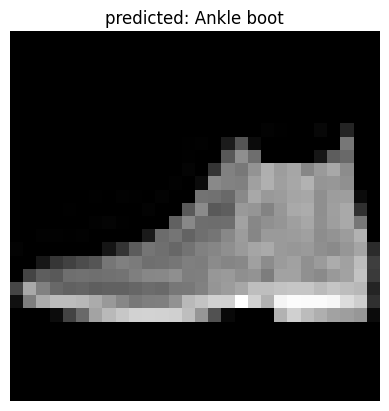

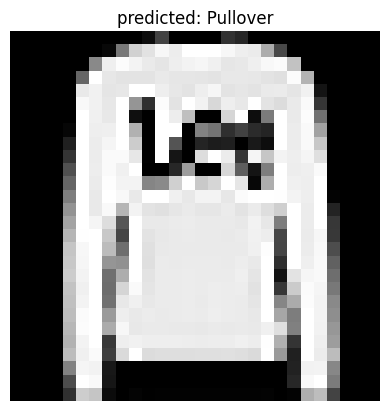

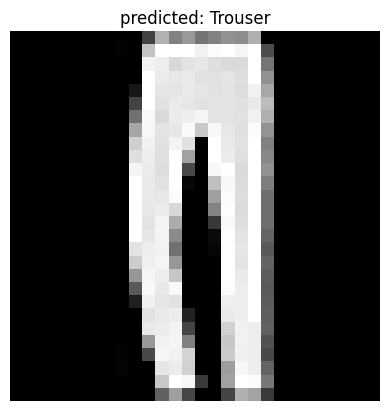

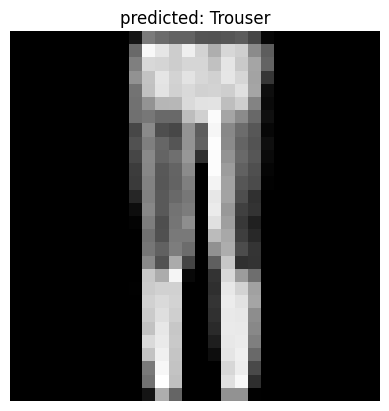

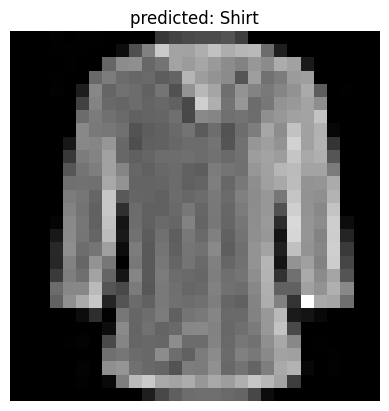

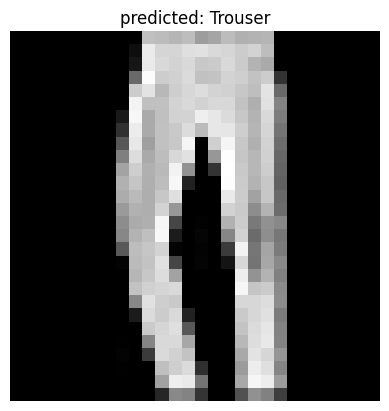

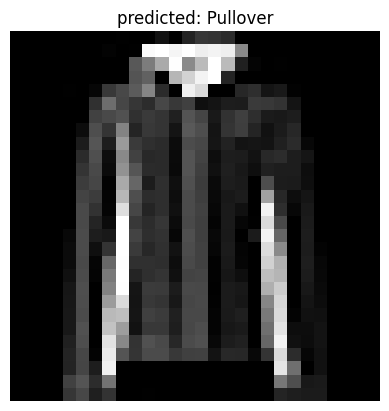

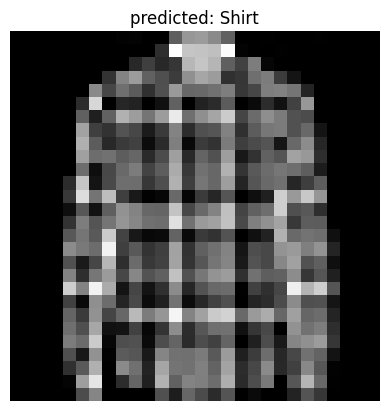

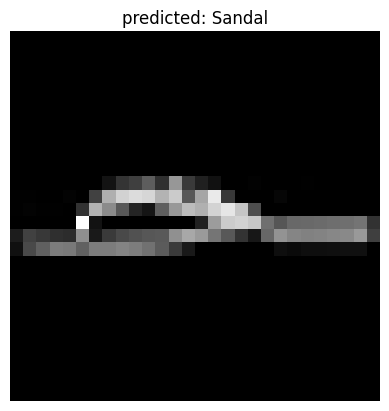

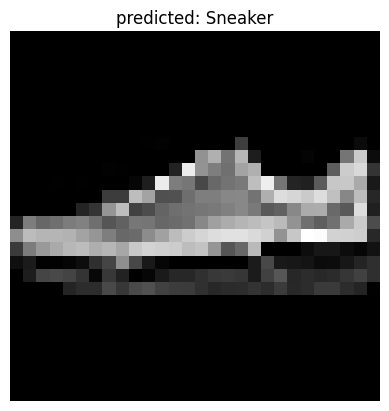

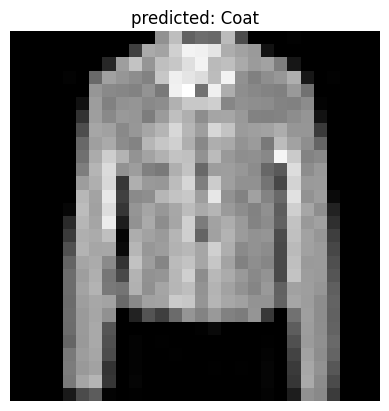

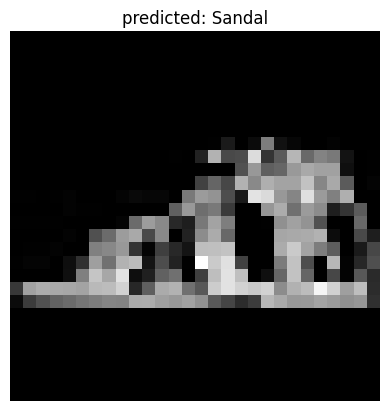

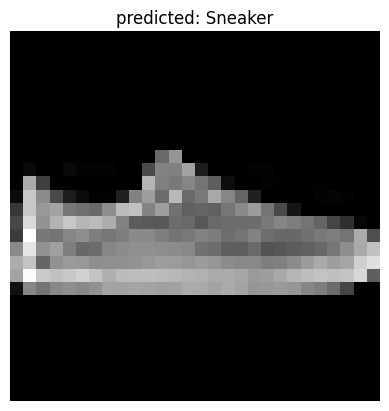

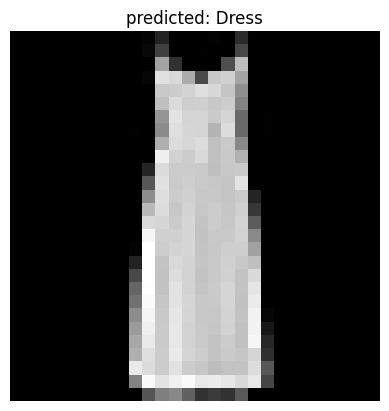

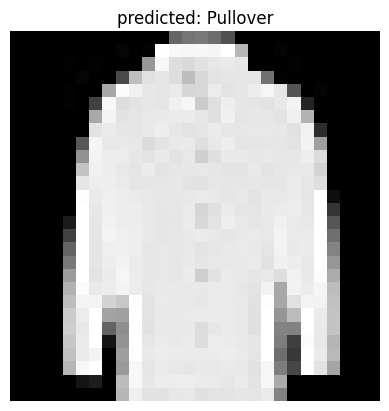

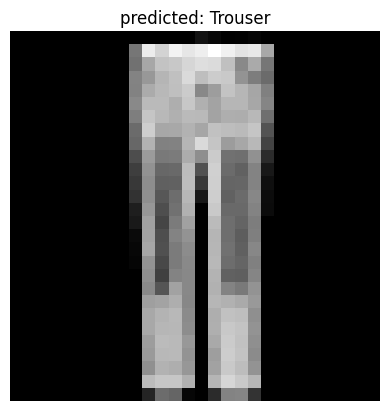

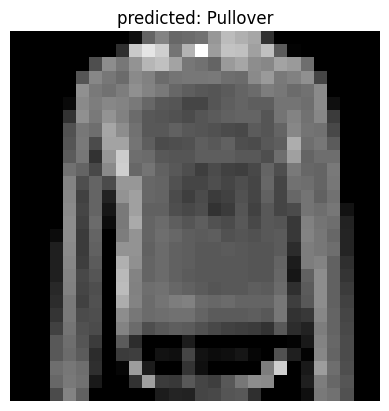

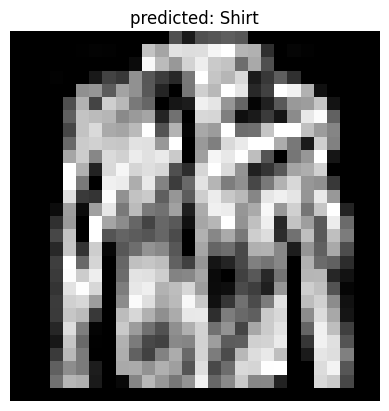

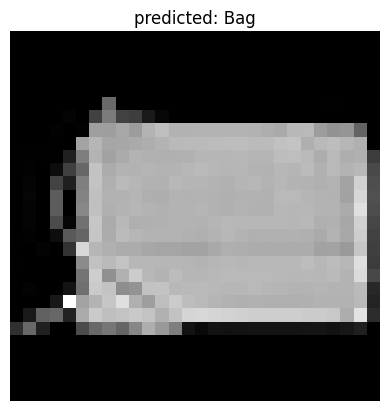

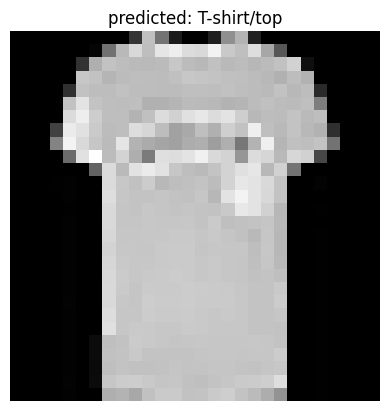

In [ ]:
# STUDENT CODE HERE (1pt)

for i in range(20):
 visualize_specific_sample(model_ft, i, test_data)

# STUDENT CODE until HERE

# Feedback and Recap

<div class="alert alert-block alert-success">
<b>Question (3pt):</b>  Please conclude in a few sentences what you learned in this exercise
</div>

<div class="alert alert-block alert-success">
<b>Your Answer: Wie können wir vortrainierte Modelle so anpassen, dass sie für unsere spezielle Aufgabe passen. -> Transfer Learning ist dafür die beste Lösung! Es ist auch wichtig zu erwähnen, dass wir sowieso keinen vollen Training machen können, da wir erstmal nicht so viele gelabelte Daten haben und zweitens keine Große GPU die Mio. von Parametern anpassen kann. Bei Transfer Learning geht es nur darum die letzten Layer (fc) zu ändern, sodass sie unserer Ausgabe erfüllen, die Layer am Anfang sind Allgemein und können wir so lassen.</b> 
</div>

## And give us feedback if you like

Subtask 7.3 is completely new designed. Especially here, feedback is very important to improve it. 


1) Do you think this task was designed well? Ja, das war super! 

2) Where can we improve this task? 

<strong>Thanks for participating in LAMA! :)</strong>